In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Bone Fracture Classification with Deep Learning

---

## 📌 **Project Overview**  
This notebook demonstrates a deep learning pipeline for **automated fracture detection** in tibia and fibula X-ray images. The dataset combines validated medical data from the University of Gondar and public repositories, addressing a critical need for robust fracture classification tools in orthopedic radiology. The workflow tackles class imbalance with advanced techniques like **Focal Loss** and **WeightedRandomSampler**, while leveraging state-of-the-art architectures like **EfficientNet-B0** and **MobileNetV2**.

---

## 📂 **Dataset Summary**  
- **Source**: X-ray images (PNG format) from:  
  - University of Gondar Referral Hospital (expert-validated)  
  - MURA (Musculoskeletal Radiographs) Dataset  
- **Task**: Binary classification (fracture vs. non-fracture) and localization.  
- **Preprocessing**: Enhanced with median/gaussian filtering, augmented via segmentation.  

---

## 🔍 **Key Challenges**  
- **Class Imbalance**: Significant skew in fracture/non-fracture cases.  
- **Medical Specificity**: High precision/recall required for clinical relevance.  

---

## 🛠️ **Analysis Pipeline**  

### 1. **Exploratory Data Analysis (EDA)**  
   - Visualized class distribution to quantify imbalance.  
   - Analyzed image quality metrics (PSNR, SSIM) post-enhancement.  

### 2. **Class Imbalance Mitigation**  
   - **WeightedRandomSampler**: Balanced mini-batches during training.  
     ```python  
     sampler = WeightedRandomSampler(  
         weights=sample_weights,  
         num_samples=len(sample_weights),  
         replacement=True  
     )  
     ```  
   - **Focal Loss**: Penalized hard-to-classify examples to reduce majority-class bias.  
   - **BCEWithLogitsLoss with PosWeight**: Adjusted loss for underrepresented fractures.    

### 3. **Model Architecture**  
   - **Transfer Learning**: Pretrained `EfficientNet-B0` and `MobileNetV2` as feature extractors.  
   - **Fine-Tuning**: Replaced classifier heads for binary output.   

---

## **Import libs | setup random seed | device**

---

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import torch
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve, 
    auc, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score
)

import warnings
warnings.filterwarnings('ignore')


def seed_everything(seed: int) -> None:
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

seed_everything(0xBADBEEF)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.has_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [4]:
dataset = ImageFolder(
    root='/kaggle/input/bone-fracture-dataset/Bone fracture dataset/Bone fracture dataset/Dataset',
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1), 
        transforms.Resize((256, 256)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  
    ])
)

## **Random samples from dataset**

---

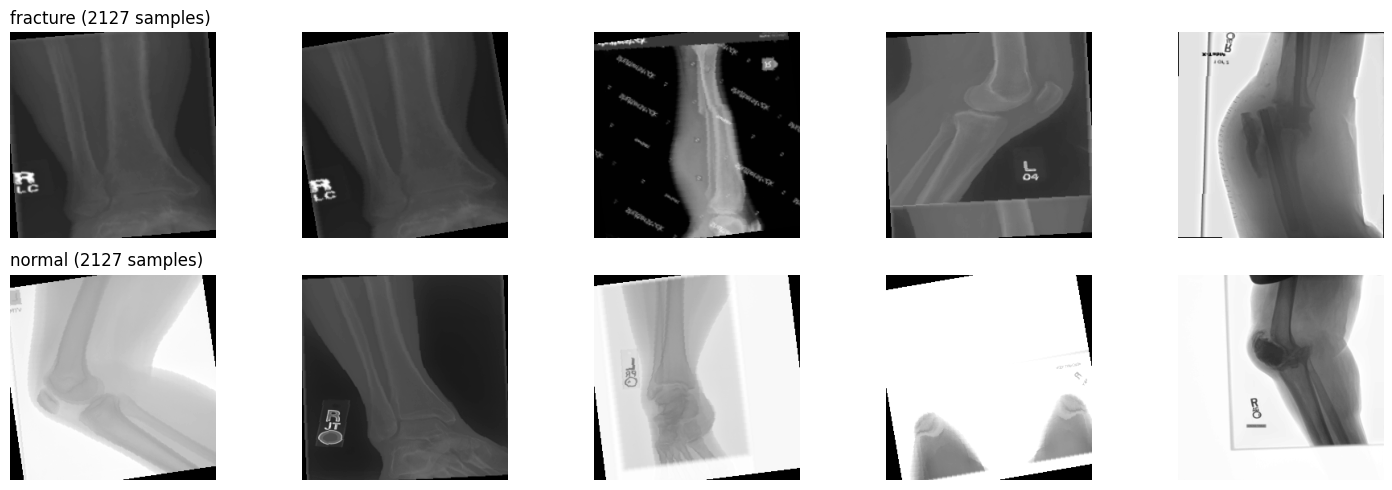

In [5]:
def show_classes_samples(dataset, num_samples=5):
    class_examples = {class_name: [] for class_name in dataset.classes}
    
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    for images, labels in loader:
        for img, label in zip(images, labels):
            class_name = dataset.classes[label]
            if len(class_examples[class_name]) < num_samples:
                class_examples[class_name].append(img)
        
        if all(len(v) >= num_samples for v in class_examples.values()):
            break

    n_classes = len(dataset.classes)
    fig, axes = plt.subplots(
        nrows=n_classes,
        ncols=num_samples,
        figsize=(15, 2.5 * n_classes), 
        squeeze=False 
    )
    
    for row_idx, class_name in enumerate(dataset.classes):
        for col_idx in range(num_samples):
            ax = axes[row_idx, col_idx]
            img = class_examples[class_name][col_idx].numpy().squeeze()
            img = img * 0.5 + 0.5 
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if col_idx == 0:
                ax.set_title(f"{class_name} ({len(dataset.targets)} samples)", loc='left')

    plt.tight_layout()
    plt.show()

show_classes_samples(dataset, num_samples=5)

## **Class Distribution Analysis: Visualizing Class Imbalance** 

---

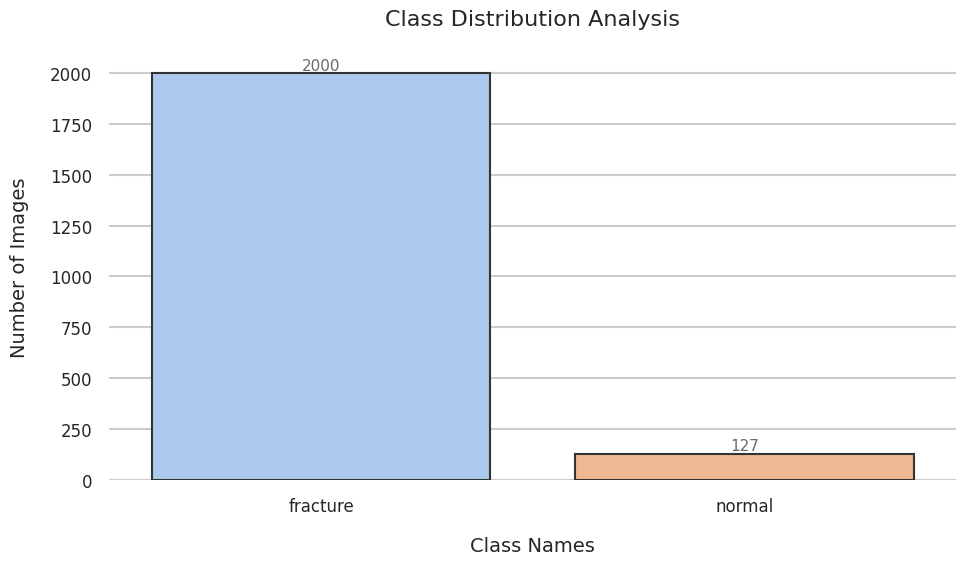

In [6]:
def plot_class_distribution(dataset):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    class_names = dataset.classes
    counts = [class_counts[i] for i in range(len(class_names))]

    sns.set(style="whitegrid", context="talk", palette="pastel")
    plt.figure(figsize=(10, 6))

    ax = sns.barplot(x=class_names, y=counts, edgecolor=".2", linewidth=1.5)
    
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 3,
                f'{int(height)}',
                ha='center', va='bottom',
                fontsize=11,
                color='dimgrey')

    ax.set_title('Class Distribution Analysis', fontsize=16, pad=20)
    ax.set_xlabel('Class Names', fontsize=14, labelpad=15)
    ax.set_ylabel('Number of Images', fontsize=14, labelpad=15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    if max(len(name) for name in class_names) > 8:
        plt.xticks(rotation=45, ha='right')
    
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

plot_class_distribution(dataset)

## **Model Initialization and Architecture Adaptation**

---

In [7]:
from torchvision.models import mobilenet_v2, efficientnet_b0

model_mobilenet_v2 = mobilenet_v2(pretrained=True)
model_efficientnet_b0 = efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 119MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


In [12]:
model_mobilenet_v2

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
model_mobilenet_v2.features[0][0] = nn.Conv2d(
    in_channels=1,                 
    out_channels=model_mobilenet_v2.features[0][0].out_channels, 
    kernel_size=model_mobilenet_v2.features[0][0].kernel_size, 
    stride=model_mobilenet_v2.features[0][0].stride, 
    padding=model_mobilenet_v2.features[0][0].padding, 
    bias=False
)

model_mobilenet_v2.classifier[1] = nn.Linear(
    in_features=model_mobilenet_v2.classifier[1].in_features, 
    out_features=1, 
    bias=True
)

model_mobilenet_v2

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [14]:
model_efficientnet_b0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model_efficientnet_b0.features[0][0] = nn.Conv2d(
    in_channels=1,                 
    out_channels=model_efficientnet_b0.features[0][0].out_channels, 
    kernel_size=model_efficientnet_b0.features[0][0].kernel_size, 
    stride=model_efficientnet_b0.features[0][0].stride, 
    padding=model_efficientnet_b0.features[0][0].padding, 
    bias=False
)

model_efficientnet_b0.classifier[1] = nn.Linear(
    in_features=model_efficientnet_b0.classifier[1].in_features, 
    out_features=1, 
    bias=True
)

model_efficientnet_b0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## **End-to-End Model Training & Performance Evaluation** 

---

In [16]:
def train(
    train_loader: DataLoader,
    test_loader: DataLoader,
    num_epochs: int = 50,
    learning_rate: float = 0.001,
    model: nn.Module = None,
    optimizer: torch.optim.Optimizer = None,
    criterion: nn.Module = None,
    device: torch.device = None
) -> tuple[nn.Module, dict]:
    
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = criterion or nn.BCEWithLogitsLoss()
    optimizer = optimizer or torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    history = {
        'train_loss': [],
        'test_loss': [],
        'metrics': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'auroc': []
        }
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).long()
        
                test_loss += criterion(outputs, labels).item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        auroc = roc_auc_score(all_labels, all_preds)
        
        history['train_loss'].append(train_loss/len(train_loader))
        history['test_loss'].append(test_loss/len(test_loader))
        history['metrics']['accuracy'].append(accuracy)
        history['metrics']['precision'].append(precision)
        history['metrics']['recall'].append(recall)
        history['metrics']['f1'].append(f1)
        history['metrics']['auroc'].append(auroc)
        
        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {history['train_loss'][-1]:.4f} | "
                  f"Test Loss: {history['test_loss'][-1]:.4f} | "
                  f"Accuracy: {accuracy:.4f}")

    plt.figure(figsize=(18, 12))

    plt.subplot(2, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
    plt.plot(history['test_loss'], label='Test Loss', linewidth=2)
    plt.title('Learning Curves', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.subplot(2, 3, 2)
    all_probs, all_labels, all_preds = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()   
            all_probs.extend(probs.squeeze().cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10, rotation=0)

    plt.subplot(2, 3, 3)
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title('ROC Curve', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='lower right')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.subplot(2, 3, (5, 6))
    metrics_data = [
        ["Accuracy", history['metrics']['accuracy'][-1]],
        ["Precision", history['metrics']['precision'][-1]],
        ["Recall", history['metrics']['recall'][-1]],
        ["F1 Score", history['metrics']['f1'][-1]],
        ["ROC AUC", roc_auc]
    ]

    table = plt.table(
        cellText=[[f"{val:.4f}"] for (_, val) in metrics_data],
        rowLabels=[name for (name, _) in metrics_data],
        colLabels=['Value'],
        loc='center',
        cellLoc='center',
        colWidths=[0.3],
        bbox=[0.1, 0.1, 0.8, 0.8]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    plt.axis('off')
    plt.title('Classification Metrics', fontsize=14, pad=20)

    plt.tight_layout(pad=3.0)
    plt.show()

    return model, history

## **Focal Loss Implementation: Addressing Class Imbalance** 

---

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        targets = targets.view(-1, 1)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

## **EfficientNet-B0 Training: Imbalance-Aware Fracture Detection Setup** 

---

Epoch 2/20 | Train Loss: 0.0132 | Test Loss: 0.0088 | Accuracy: 0.9930
Epoch 4/20 | Train Loss: 0.0138 | Test Loss: 0.0039 | Accuracy: 0.9953
Epoch 6/20 | Train Loss: 0.0085 | Test Loss: 0.0067 | Accuracy: 0.9930
Epoch 8/20 | Train Loss: 0.0076 | Test Loss: 0.0104 | Accuracy: 0.9883
Epoch 10/20 | Train Loss: 0.0076 | Test Loss: 0.0044 | Accuracy: 0.9930
Epoch 12/20 | Train Loss: 0.0035 | Test Loss: 0.0041 | Accuracy: 0.9977
Epoch 14/20 | Train Loss: 0.0036 | Test Loss: 0.0031 | Accuracy: 0.9977
Epoch 16/20 | Train Loss: 0.0055 | Test Loss: 0.0010 | Accuracy: 1.0000
Epoch 18/20 | Train Loss: 0.0055 | Test Loss: 0.0034 | Accuracy: 0.9977
Epoch 20/20 | Train Loss: 0.0063 | Test Loss: 0.0012 | Accuracy: 1.0000


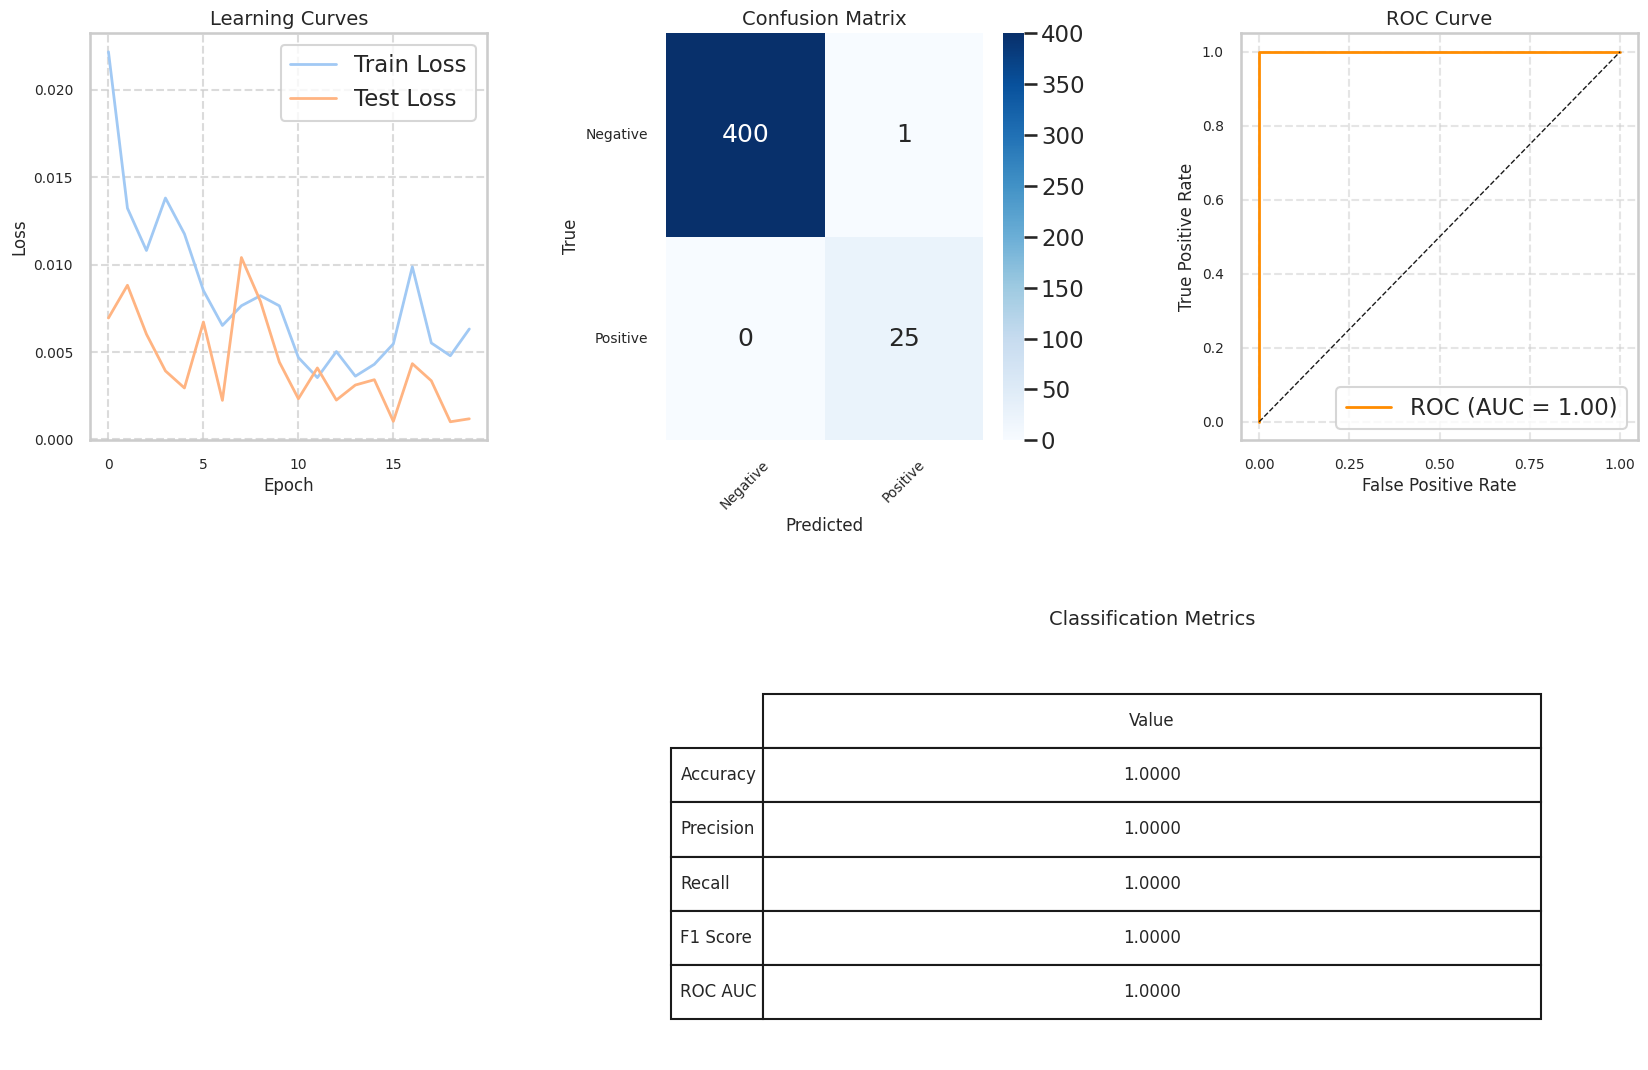

In [20]:
# model_efficientnet_b0
# model_mobilenet_v2

train_set, val_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model_efficientnet_b0.parameters(), lr=1e-4)

res_model = train(
    train_dataloader,
    val_dataloader,
    num_epochs=20,
    learning_rate=1e-4,
    model=model_efficientnet_b0,
    optimizer=optimizer,
    criterion=criterion,
    device=device
)

## **MobileNetV2 Training: Imbalance Handling Strategy** 

---

Epoch 2/18 | Train Loss: 0.0632 | Test Loss: 0.0398 | Accuracy: 0.9977
Epoch 4/18 | Train Loss: 0.0611 | Test Loss: 0.0255 | Accuracy: 1.0000
Epoch 6/18 | Train Loss: 0.0565 | Test Loss: 0.0155 | Accuracy: 1.0000
Epoch 8/18 | Train Loss: 0.0417 | Test Loss: 0.0181 | Accuracy: 0.9977
Epoch 10/18 | Train Loss: 0.0219 | Test Loss: 0.0215 | Accuracy: 1.0000
Epoch 12/18 | Train Loss: 0.0269 | Test Loss: 0.0082 | Accuracy: 0.9977
Epoch 14/18 | Train Loss: 0.0100 | Test Loss: 0.0057 | Accuracy: 1.0000
Epoch 16/18 | Train Loss: 0.0144 | Test Loss: 0.0024 | Accuracy: 1.0000
Epoch 18/18 | Train Loss: 0.0162 | Test Loss: 0.0054 | Accuracy: 1.0000


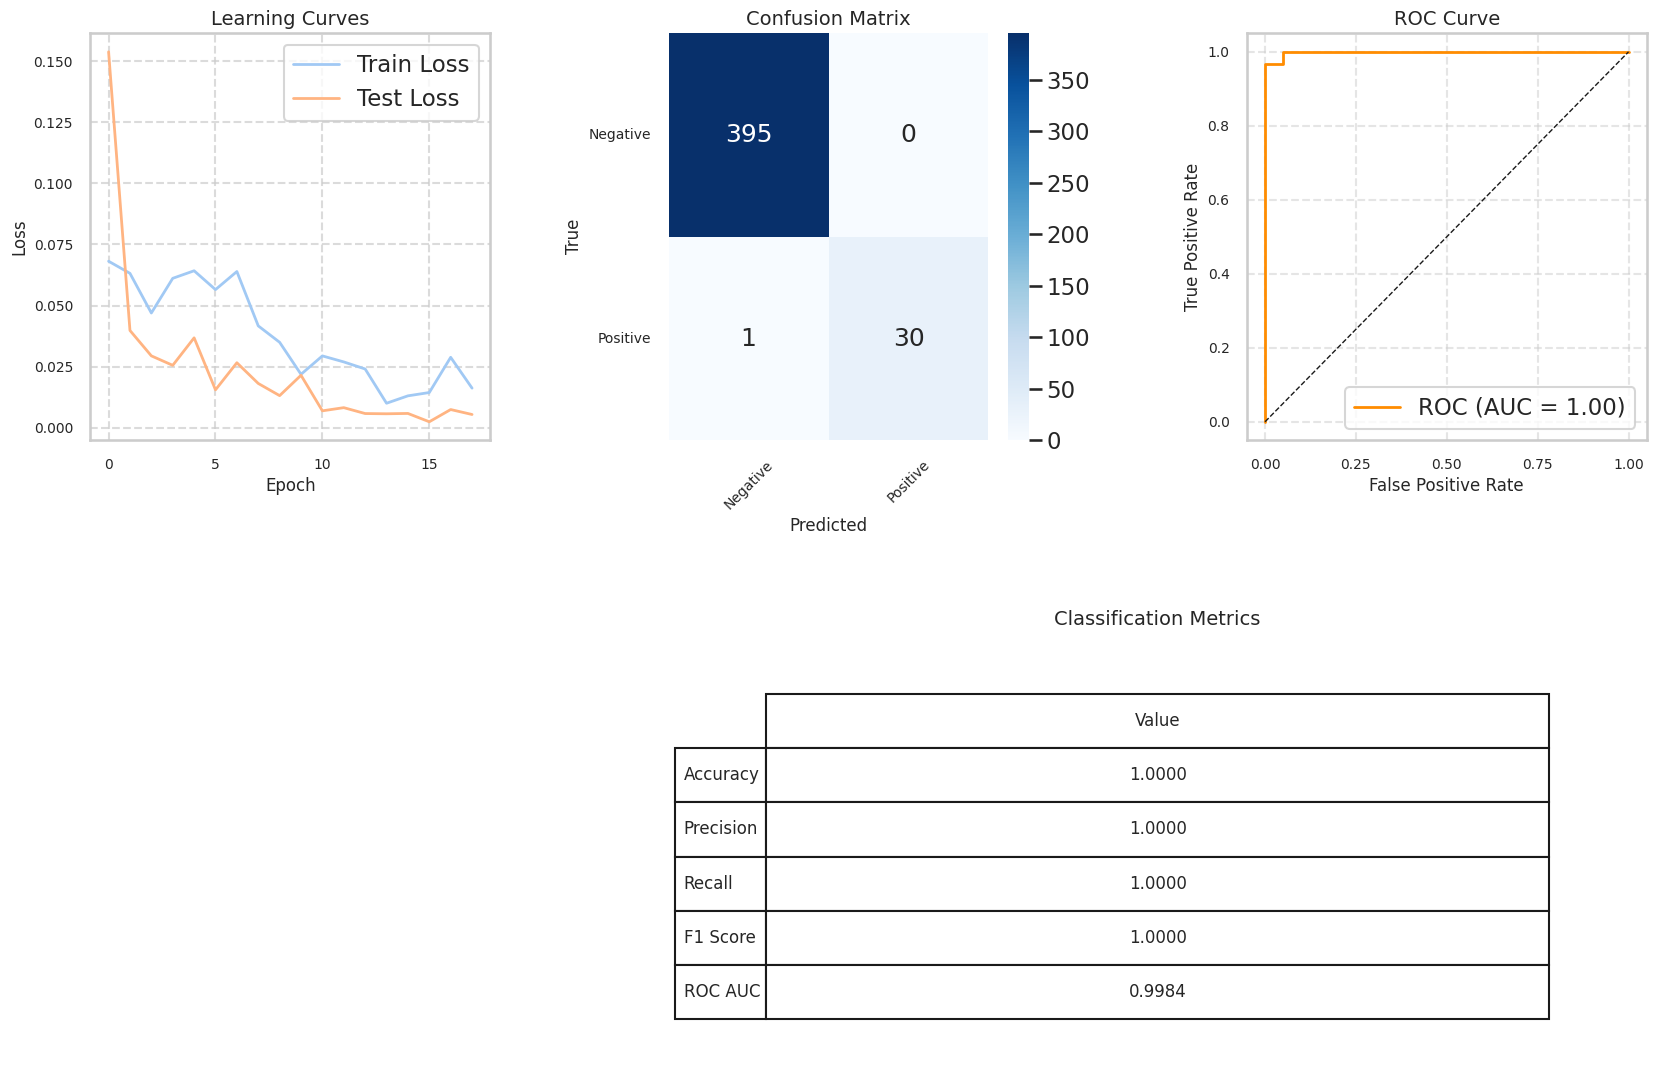

In [23]:
from torch.utils.data.sampler import WeightedRandomSampler

class_counts = torch.bincount(torch.tensor(dataset.targets))
class_weights = 1. / class_counts.float()
sample_weights = class_weights[dataset.targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

train_set, val_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=128,
    shuffle=False,
    num_workers=4,
)

pos_weight = class_counts[0] / class_counts[1]
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model_mobilenet_v2.parameters(), lr=1e-4)

res_model = train(
    train_dataloader,
    val_dataloader,
    num_epochs=18,
    learning_rate=1e-4,
    model=model_mobilenet_v2,
    optimizer=optimizer,
    criterion=criterion,
    device=device
)